# ConSBind Performance Analysis
***

In this notebook we will analyse ConSBind's binding site prediction performance across different protein classes:
 - Enzymes
 - Transporters
 - Receptors
 - Challenging cases

## Setup

First, let's import the necessary modules and set up logging.

In [1]:
import os
import sys
import random
import subprocess
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
import seaborn as sns
from pathlib import Path
from tqdm.notebook import tqdm
from Bio.PDB import PDBList, PDBParser, Selection
from Bio.PDB.Polypeptide import standard_aa_names
from scipy.spatial import distance
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import logging
logger = logging.getLogger(__name__)

from ConSBind.input.file_handler import convert_ent_to_pdb, find_pdb_files
from ConSBind.core.structure import ProteinStructure
from ConSBind.core.finder import ConsensusPocketFinder
from ConSBind.core.scoring import final_scoring
from ConSBind.output.output import save_predictions, save_pymol, save_chimera

import Analysis

## Define Protein Classes & Ligands

In [2]:
PROTEIN_CLASSES = {"enzymes": {"1DLS": "Dihydrofolate reductase",
                               "1LZE": "Lysozyme",
                               "1FXY": "Trypsin",
                               "1RNM": "Ribonuclease A",
                               "2CBA": "Carbonic anhydrase II"},
                   "transporters": {"1MBO": "Myoglobin",
                                    "1RBP": "Retinol binding protein",
                                    "1ANF": "Maltose binding protein",
                                    "1GZX": "Hemoglobin",
                                    "5GGE": "Fatty acid binding protein"},
                   "receptors": {"1RDT": "Retinoid X receptor",
                                 "1FM9": "Peroxisome proliferator-activated receptor",
                                 "181L": "T4 lysozyme L99A mutant",
                                 "1FKF": "FK506 binding protein",
                                 "1A28": "Progesterone receptor"},
                   "challenging": {"2RH1": "Beta-2 adrenergic receptor",
                                   "6QEX": "P-glycoprotein",
                                   "4I8V": "Cytochrome P450", 
                                   "2GIF": "Bacterial multidrug efflux transporter AcrB",
                                   "1QS4": "HIV integrase",
                                   "1TRB": "Thioredoxin reductase"}}

ligands = ['MTX', 'NDP', 'NAG', '0G6', '2GP', 'ZN', 'HEM', 'O2', 'RTL', 'MAL', 'CIT', '9CR', 
           'GW5', 'BNZ', 'FK5', 'STR', 'CAU', '6N8', 'NAG', 'MIY','100', 'FAD', 'NAD']

## Data Organization and Download

In [3]:
base_dir = Path(os.getcwd()) / "data" / "analysis"
base_dir.mkdir(parents=True, exist_ok=True)

for protein_class in PROTEIN_CLASSES:
    class_dir = base_dir / protein_class
    class_dir.mkdir(exist_ok=True)

### Download PDB Structures

In [4]:
pdb_list = PDBList()
    
for protein_class, proteins in PROTEIN_CLASSES.items():
    class_dir = base_dir / protein_class
        
    for pdb_id in tqdm(proteins.keys(), desc = f"Downloading {protein_class}"):
        pdb_file = pdb_list.retrieve_pdb_file(
            pdb_code = pdb_id,
            file_format = "pdb",
            pdir = str(class_dir)
        )

## Extract Known Binding Sites

We extract binding sites from the structures by identifying ligands and their surrounding residues by a cuttof of `4Å`.

In [5]:
KNOWN_BINDING_SITES = {}; binding_sites = {}
global KNOWN_BINDING_SITES
   
for protein_class, proteins in PROTEIN_CLASSES.items():
    class_dir = base_dir / protein_class
        
    for pdb_id in tqdm(proteins.keys(), desc=f"Extracting binding sites from {protein_class}"):
        pdb_file = class_dir / f"pdb{pdb_id}.ent"  
        if not pdb_file.exists():
            logger.warning(f"PDB file not found: {pdb_file}")
            continue 
        try:
            parser = PDBParser(QUIET=True)
            structure = parser.get_structure(pdb_id, pdb_file)
            residues = Selection.unfold_entities(structure, "R")
                
            potential_ligands = []; known_ligands = []
            for residue in residues:
                res_name = residue.get_resname()
                if res_name in standard_aa_names:
                    continue
                
                if res_name in ligands:
                    known_ligands.append(residue)
                else:
                    if res_name not in ['HOH', 'WAT', 'TIP', 'SOL']:
                        potential_ligands.append(residue)
                
            ligand_residues = known_ligands if known_ligands else potential_ligands
            if not ligand_residues:
                logger.warning(f"No ligands found in {pdb_id}")
                continue
            print(f"Found {len(ligand_residues)} ligands in {pdb_id}")
                
            all_binding_site_residues = []
            for ligand in ligand_residues:
                ligand_atoms = list(ligand.get_atoms())
                if not ligand_atoms:
                    continue
                                        
                binding_site_residues = []
                for residue in residues:
                    if residue.get_resname() not in standard_aa_names or residue == ligand:
                        continue  
                    for atom in residue:
                        for ligand_atom in ligand_atoms:
                            dist = np.linalg.norm(atom.get_coord() - ligand_atom.get_coord())
                            if dist < 4.0:  # 4Å cutoff for binding site
                                binding_site_residues.append(residue)
                                break
                        else:
                            continue
                        break
                    
                all_binding_site_residues.extend(binding_site_residues)

            unique_residues = []
            for res in all_binding_site_residues:
                if res not in unique_residues:
                    unique_residues.append(res)
            if unique_residues:
                binding_sites[pdb_id] = [
                    (res.get_parent().id, res.get_id()[1]) 
                    for res in unique_residues
                ]
        except Exception as e:
            logger.error(f"Error processing {pdb_id}: {e}")
    
KNOWN_BINDING_SITES.update(binding_sites)

print(f"Found binding sites for {len(binding_sites)} proteins")
print(f"Using {len(ligands)} ligand types for binding site detection")

Extracting binding sites from enzymes:   0%|          | 0/5 [00:00<?, ?it/s]

Found 2 ligands in 1DLS
Found 4 ligands in 1LZE
Found 1 ligands in 1FXY
Found 4 ligands in 1RNM
Found 1 ligands in 2CBA


Extracting binding sites from transporters:   0%|          | 0/5 [00:00<?, ?it/s]

Found 1 ligands in 1MBO
Found 1 ligands in 1RBP
Found 2 ligands in 1ANF
Found 4 ligands in 1GZX
Found 1 ligands in 5GGE


Extracting binding sites from receptors:   0%|          | 0/5 [00:00<?, ?it/s]

Found 2 ligands in 1RDT
Found 1 ligands in 1FM9
Found 1 ligands in 181L
Found 1 ligands in 1FKF
Found 2 ligands in 1A28


Extracting binding sites from challenging:   0%|          | 0/6 [00:00<?, ?it/s]

Found 1 ligands in 2RH1
Found 3 ligands in 6QEX
Found 4 ligands in 4I8V
Found 2 ligands in 2GIF
Found 1 ligands in 1QS4
Found 1 ligands in 1TRB
Found binding sites for 21 proteins
Using 23 ligand types for binding site detection


## Run ConSBind Predictions
We run ConSBind predictions using bash commands for each protein structure.

In [6]:
output_dir = Path(os.getcwd()) / "results" / "analysis"; output_dir.mkdir(exist_ok=True)
    
for protein_class, proteins in PROTEIN_CLASSES.items():
    class_dir = base_dir / protein_class
    class_output_dir = output_dir / protein_class
    class_output_dir.mkdir(exist_ok=True)
        
    print(f"Processing {len(proteins)} proteins for class: {protein_class}")
    for pdb_id in tqdm(proteins.keys(), desc=f"Running predictions for {protein_class}"):
        pdb_file = class_dir / f"pdb{pdb_id}.ent"
            
        if not pdb_file.exists():
            logger.warning(f"PDB file not found: {pdb_file}")
            continue
            
        if protein_class == 'enzymes':
            protein_type = 'enzyme'
        elif protein_class == 'transporters':
            protein_type = 'transporter'
        elif protein_class == 'receptors':
            protein_type = 'receptor'
        else:
            protein_type = 'unknown'
            
        # Run ConSBind using command line
        cmd = f"consbind {pdb_file} --output_dir {class_output_dir} --protein_type {protein_type} > /dev/null 2>&1"
            
        try:
            print(f"Running command: {cmd}")
            !{cmd}
        except Exception as e:
            logger.error(f"Error running prediction for {pdb_id}: {e}")

Processing 5 proteins for class: enzymes


Running predictions for enzymes:   0%|          | 0/5 [00:00<?, ?it/s]

Running command: consbind /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/data/analysis/enzymes/pdb1DLS.ent --output_dir /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/results/analysis/enzymes --protein_type enzyme > /dev/null 2>&1
Running command: consbind /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/data/analysis/enzymes/pdb1LZE.ent --output_dir /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/results/analysis/enzymes --protein_type enzyme > /dev/null 2>&1
Running command: consbind /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/data/analysis/enzymes/pdb1FXY.ent --output_dir /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/results/analysis/enzymes --protein_type enzyme > /dev/null 2>&1
Running command: consbind /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/data/analysis/enzymes/pdb1RNM.ent --output_dir /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/results/analysis/enzymes --protein_type enzyme > /dev/null 2>&1
Running command: consbind /Users/claudiavice

Running predictions for transporters:   0%|          | 0/5 [00:00<?, ?it/s]

Running command: consbind /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/data/analysis/transporters/pdb1MBO.ent --output_dir /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/results/analysis/transporters --protein_type transporter > /dev/null 2>&1
Running command: consbind /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/data/analysis/transporters/pdb1RBP.ent --output_dir /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/results/analysis/transporters --protein_type transporter > /dev/null 2>&1
Running command: consbind /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/data/analysis/transporters/pdb1ANF.ent --output_dir /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/results/analysis/transporters --protein_type transporter > /dev/null 2>&1
Running command: consbind /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/data/analysis/transporters/pdb1GZX.ent --output_dir /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/results/analysis/transporters --protein_type transporter >

Running predictions for receptors:   0%|          | 0/5 [00:00<?, ?it/s]

Running command: consbind /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/data/analysis/receptors/pdb1RDT.ent --output_dir /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/results/analysis/receptors --protein_type receptor > /dev/null 2>&1
Running command: consbind /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/data/analysis/receptors/pdb1FM9.ent --output_dir /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/results/analysis/receptors --protein_type receptor > /dev/null 2>&1
Running command: consbind /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/data/analysis/receptors/pdb181L.ent --output_dir /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/results/analysis/receptors --protein_type receptor > /dev/null 2>&1
Running command: consbind /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/data/analysis/receptors/pdb1FKF.ent --output_dir /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/results/analysis/receptors --protein_type receptor > /dev/null 2>&1
Running command: con

Running predictions for challenging:   0%|          | 0/6 [00:00<?, ?it/s]

Running command: consbind /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/data/analysis/challenging/pdb2RH1.ent --output_dir /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/results/analysis/challenging --protein_type unknown > /dev/null 2>&1
Running command: consbind /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/data/analysis/challenging/pdb6QEX.ent --output_dir /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/results/analysis/challenging --protein_type unknown > /dev/null 2>&1
Running command: consbind /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/data/analysis/challenging/pdb4I8V.ent --output_dir /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/results/analysis/challenging --protein_type unknown > /dev/null 2>&1
Running command: consbind /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/data/analysis/challenging/pdb2GIF.ent --output_dir /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/results/analysis/challenging --protein_type unknown > /dev/null 2>&1
Running 

##  Evaluate Predictions

In [7]:
Analysis.PROTEIN_CLASSES = PROTEIN_CLASSES; Analysis.logger = logger; 
Analysis.KNOWN_BINDING_SITES = KNOWN_BINDING_SITES; Analysis.base_dir = base_dir
Analysis.standard_aa_names = standard_aa_names; Analysis.convert_ent_to_pdb = convert_ent_to_pdb
Analysis.ProteinStructure = ProteinStructure

results_df = Analysis.evaluate_predictions()
results_df.head()

Evaluating challenging: 100%|███████████████████| 6/6 [00:23<00:00,  3.91s/it]


,pdb_id,protein_class,protein_description,protein_complexity,precision,recall,f1_score,spatial_overlap,center_distance,volume_similarity,pocket_depth,pocket_polarity,num_predictions,consensus_score,binding_potential_score,druggability_score,knowledge_based_score
0,1DLS,enzymes,Dihydrofolate reductase,3.976598,0.213115,0.317073,0.254902,0.180915,11.732600,0.815993,5.052303,0.313933,79,3.0,31.93,0.45,1.5
1,1LZE,enzymes,Lysozyme,3.822601,0.000000,0.000000,0.000000,0.005167,16.669319,0.957963,3.450404,0.380952,18,1.3,6.58,0.17,3.5
2,1FXY,enzymes,Trypsin,4.317979,0.000000,0.000000,0.000000,0.001811,19.624344,0.369059,4.144332,0.283401,66,3.0,10.79,0.38,1.5
3,1RNM,enzymes,Ribonuclease A,3.414981,0.132075,0.933333,0.231405,0.179802,3.404149,0.191788,6.077626,0.381057,144,1.3,6.20,0.00,3.0
4,2CBA,enzymes,Carbonic anhydrase II,4.216346,0.050000,0.750000,0.093750,0.078491,10.098734,0.098256,7.198360,0.307071,73,3.0,11.85,0.31,1.5


## Visualization and Interpretation of Results

In [8]:
res = results_df.columns.tolist() 
class_colors = ["#FFC300", "#FF5733", "#C70039", "#900C3F"]
classes = results_df["protein_class"].unique()
colfun = {protein_class: class_colors[i % len(class_colors)] 
              for i, protein_class in enumerate(classes)}

### Initial Performance Distribution by Protein Class

The figure below presents a comparative analysis of key evaluation metrics across four protein categories: **enzymes**, **transporters**, **receptors**, and **challenging proteins**. Each boxplot shows the distribution of metric values for the proteins in each class.


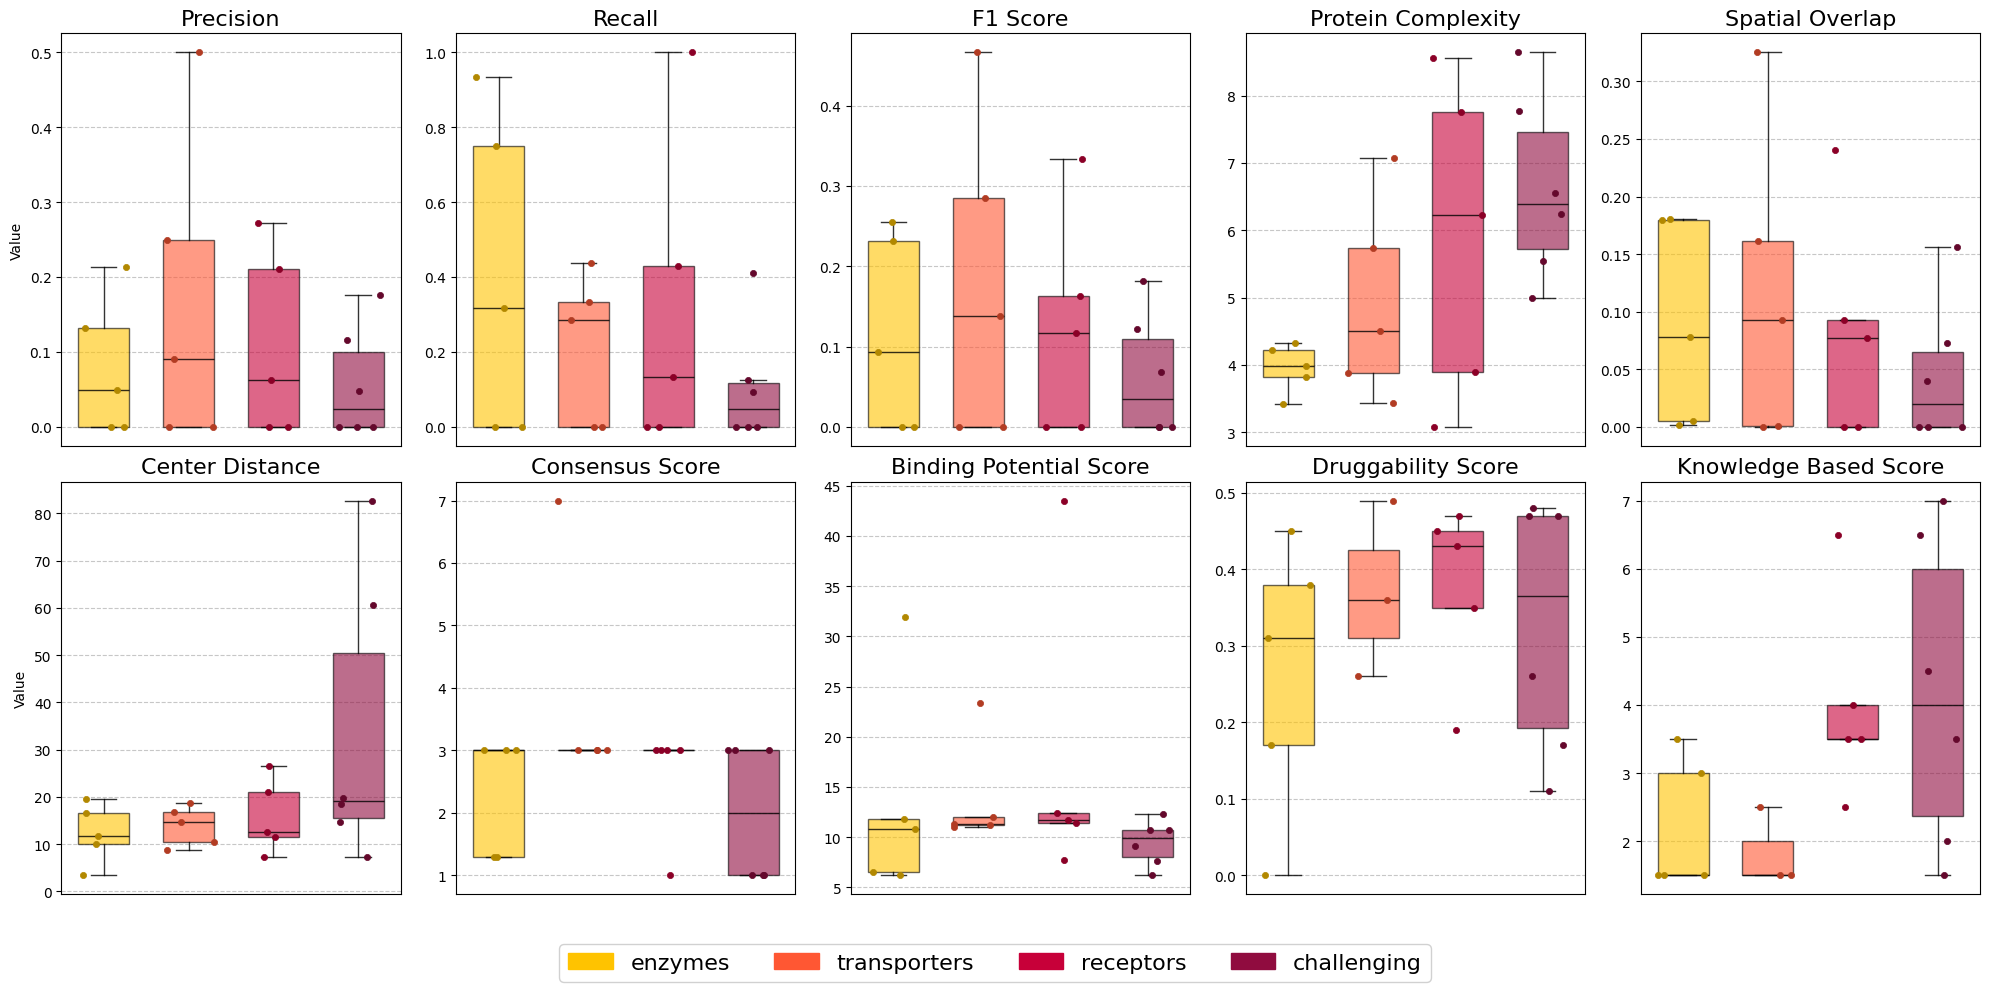

In [9]:
def hex_to_rgb(hex_code):
    return np.array([int(hex_code.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)])
def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]), int(rgb[1]), int(rgb[2]))
def darken_color(hex_code, factor=0.7):
    return rgb_to_hex(np.clip(hex_to_rgb(hex_code) * factor, 0, 255))

metrics = [res[4], res[5], res[6], res[3], res[7], res[8], res[13], res[14], res[15], res[16]]
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()
jitter_data = [[] for _ in range(len(metrics))]

for i, metric in enumerate(metrics):
    ax = axes[i]
    for j, cls in enumerate(colfun.keys()):
        class_data = results_df[results_df['protein_class'] == cls]
        pos = j + 1
        color = colfun[cls]
        
        boxplot = ax.boxplot(class_data[metric].dropna(), positions = [pos], 
                             widths = 0.6, patch_artist = True, showfliers = False)
        for patch in boxplot['boxes']:
            patch.set_facecolor(color); patch.set_alpha(0.6)
        for element in ['whiskers', 'caps', 'medians']:
            for line in boxplot[element]:
                line.set_color('black'); line.set_alpha(0.8)
        
        data_points = class_data[metric].dropna()
        if len(data_points) > 0:
            jitter_x = [pos + (random.uniform(-0.3, 0.3)) for _ in range(len(data_points))]
            base_color = color
            darker_color = darken_color(base_color, factor=0.7)
            jitter_data[i].append((jitter_x, data_points, darker_color))
    
    ax.set_title(metric.replace('_', ' ').title(),fontsize=16)
    ax.set_xticks([]); ax.grid(True, linestyle='--', alpha=0.7)
    if i % 5 == 0:
        ax.set_ylabel('Value')

for i, metric_jitter in enumerate(jitter_data):
    ax = axes[i]
    for jitter_x, data_points, color in metric_jitter:
        ax.scatter(jitter_x, data_points, s = 20, color = color,
                   edgecolor = color, linewidth = 0.5, zorder = 10)

legend_handles = [plt.Rectangle((0,0), 1, 1, color=class_colors[i % len(class_colors)]) 
                  for i in range(len(classes))]
fig.legend(legend_handles, classes, loc='lower center', ncol = len(classes), 
           fontsize = 16, frameon = True, framealpha = 0.9)

plt.tight_layout(); plt.subplots_adjust(bottom = 0.1); plt.show()


#### Classification Metrics (Precision, Recall, F1 Score)

- **Enzymes** exhibit the **highest recall** (median `~0.35`), meaning the model successfully detects most true binding residues. However, their **precision is low** (`~0.05`), indicating a high false positive rate.
- **Transporters** show a **more balanced profile**, with moderate recall and higher precision compared to enzymes. As a result, they yield the **highest F1 scores**, highlighting the best trade-off between precision and recall.
- **Receptors** fall in between, with **moderate performance** on all three metrics, slightly outperforming enzymes in precision.
- **Challenging proteins** consistently show the **lowest scores across all metrics**, reflecting the difficulty of accurately predicting their binding sites.

#### Protein Complexity

- The **protein complexity** score clearly differentiates the classes. Challenging proteins have the **highest complexity**, followed by receptors and transporters, with enzymes being the simplest.
- This aligns with performance trends: **greater complexity correlates with poorer prediction outcomes**.

#### Spatial & Geometric Metrics (Spatial Overlap, Center Distance)

- **Enzymes** and **transporters** tend to have **lower center distances** and **higher spatial overlap**, indicating better spatial alignment with known binding pockets.
- **Challenging proteins** have the **worst spatial metrics**, reinforcing their poor overall predictability.

#### Scoring System Metrics (Consensus, Binding Potential, Druggability, Knowledge-Based)

Our algorithm generates a set of complementary scoring outputs for each predicted binding site, each capturing different aspects of binding relevance, which are also included in the plot above.
These scores offer **complementary validation signals**. For instance, a site with high consensus and binding potential but low knowledge-based score might represent a novel or previously uncharacterized binding pocket. Conversely, high values across all scores typically indicate a confident, canonical site likely to be functional.

While these scores are valuable for **ranking and interpreting predictions**, they are **not objective measures of correctness**. They do not compare the predicted site to the actual, experimentally known ligand-binding site. As such, **a high internal score does not necessarily mean the prediction overlaps with the real binding site**. To truly evaluate performance, we rely on the external metrics commented before like **F1-score**, **spatial overlap**, and **center distance to the real site**.


### Interpreting Metric Correlations and the Scoring System

To deepen our understanding of how the scoring metrics interrelate and which ones are more reliable indicators of meaningful biological predictions, we analyze the correlation matrix shown below:

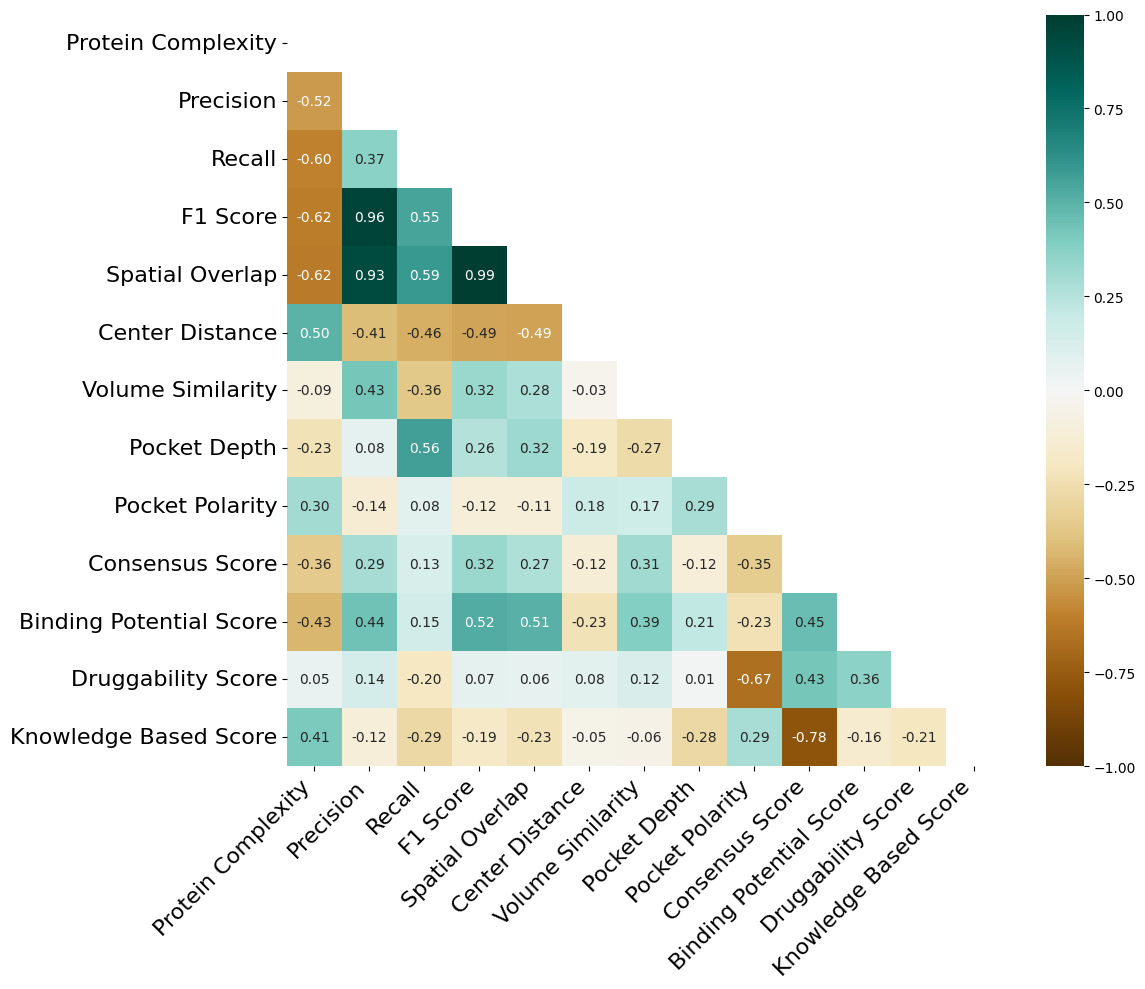

In [10]:
metrics = [item for i, item in enumerate(res) if i not in [0, 1, 2, 12, 17]]
plt.figure(figsize=(12, 10))
plt.rcParams['axes.grid'] = False
heatmap = sns.heatmap(results_df[metrics].corr(), 
                      mask=np.triu(np.ones_like(results_df[metrics].corr(), dtype=bool)), 
                      annot=True, cmap='BrBG', vmin=-1, vmax=1, fmt='.2f')

plt.xticks(np.arange(len(metrics))+0.5, [metric.replace('_', ' ').title() for metric in metrics], rotation=45, ha='right', fontsize=16)
plt.yticks(np.arange(len(metrics))+0.5, [metric.replace('_', ' ').title() for metric in metrics], fontsize=16)

plt.tight_layout()
plt.show()

We observe a **near-perfect correlation (`0.99`) between spatial overlap and F1-score**, highlighting that spatial overlap might serve as a strong proxy for classification performance. This makes intuitive sense since F1-score balances precision and recall, and spatial overlap similarly captures both sensitivity and accuracy in the context of spatial predictions.

Another striking observation is the **negative correlation between protein complexity and core classification metrics**—precision (`-0.52`), recall (`-0.60`), and F1-score (`-0.62`). This confirms our earlier insight: **more structurally complex proteins are inherently harder to predict with our approach**, regardless of the metric used. Interestingly, **volume, depth, and polarity of the predicted pockets show weak or no correlation** with performance metrics. This reinforces the idea that it is not individual physical characteristics but rather their **combined complexity**, captured under the umbrella of "Protein Complexity"; that significantly impairs prediction performance.

#### Understanding Protein Complexity

We quantify protein complexity through multiple complementary dimensions:

- **Size**: Larger proteins naturally present more potential binding surfaces, increasing the number of false positive regions and raising the prediction difficulty.
- **Domain architecture**: Multi-domain proteins pose unique challenges, especially when binding regions are located at **domain interfaces**, where structural transitions can be more dynamic or ambiguous.
- **Flexibility**: High **B-factors** indicate local flexibility and thermal motion, which often correlate with conformational variability—making these regions difficult to predict with rigid structure-based methods.
- **Binding site accessibility**: The degree to which binding sites are **buried** versus **surface-exposed** strongly impacts detectability. Buried or partially occluded sites, even if druggable, are harder to detect using surface-based scoring alone.

This complexity analysis explains why **"challenging" proteins consistently show the poorest performance** across our metric suite. These proteins frequently combine multiple complexity factors: they tend to be **large, multi-domain structures with flexible binding regions**, often located at **interfaces or within environments that mix buried and exposed features**.

#### Limitations of Traditional Classification Metrics

Traditional metrics like precision, recall, and F1-score depend on:

- **Severe class imbalance**: Binding sites typically constitute only `5–15%` of protein surface residues, creating class imbalance that distorts the interpretation of false positives and false negatives.
- **Loss of spatial relationships**: These metrics treat each residue independently, disregarding the spatial coherence of the predicted binding site, which may be biologically nonsensical.
- **Arbitrary boundary definitions**: Classifying protein residues as binding/non-binding requires setting arbitrary distance thresholds from ligands (`4Å` in our analysis), creating artificial binary distinctions in what is actually a continuous spatial relationship. The sensitivity of metrics to real-binding site threshold choice, can be seen in the boxplots below comparing performance at two commonly used cutoffs: `4Å` and `6Å` from the ligand:

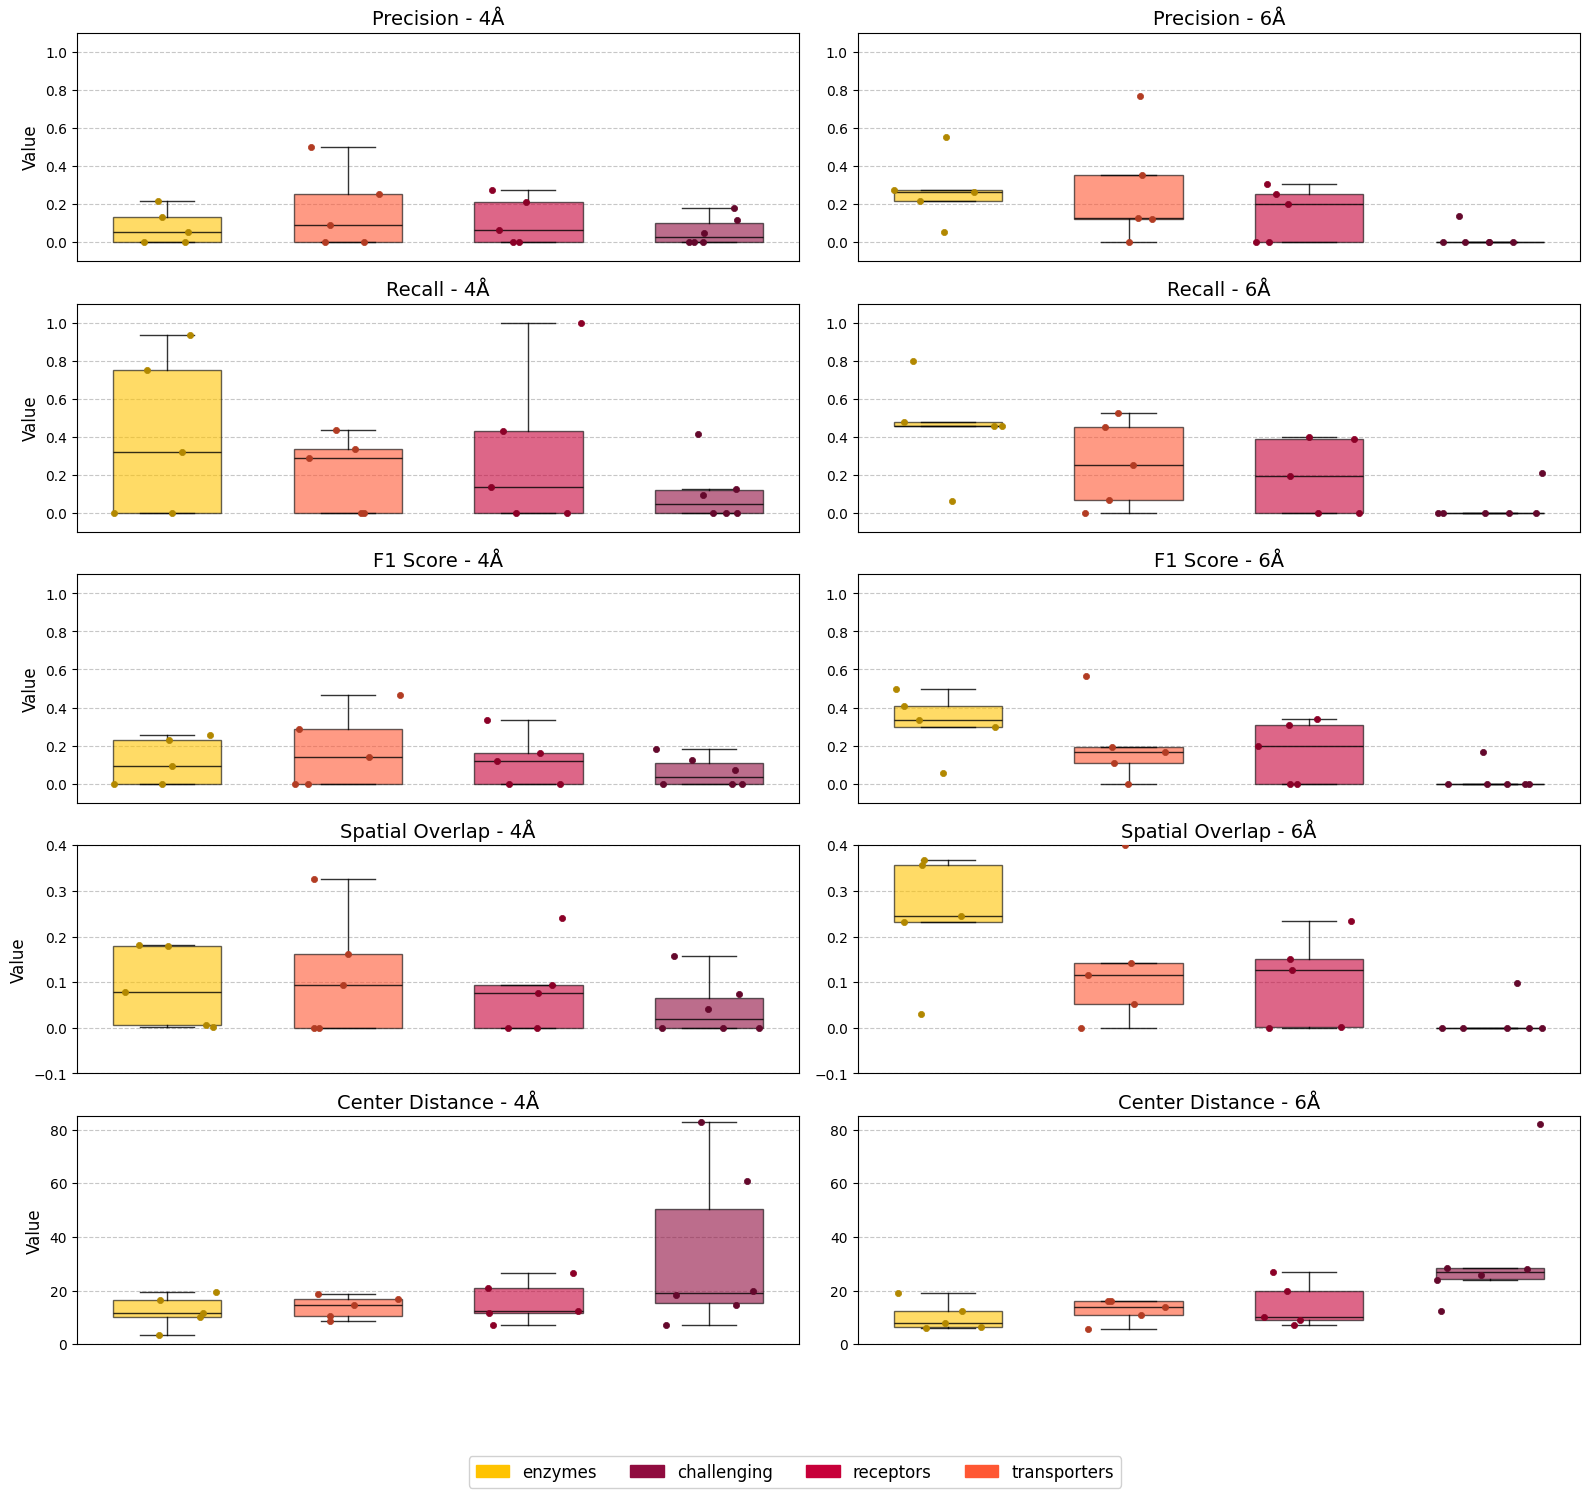

In [42]:
results_df_6A = pd.read_csv('results/analysis/results_6A.csv')

metrics = [res[4], res[5], res[6], res[7], res[8]]
fig, axes = plt.subplots(len(metrics), 2, figsize=(16, 3 * len(metrics)))
y_limits = [(-0.1, 1.1), (-0.1, 1.1), (-0.1, 1.1), (-0.1, 0.40), (0, 85)]
for i, metric in enumerate(metrics):
    ax_left = axes[i, 0]; ax_right = axes[i, 1]
    ax_left.set_title(f"{metric.replace('_', ' ').title()} - 4Å", fontsize=14)
    ax_right.set_title(f"{metric.replace('_', ' ').title()} - 6Å", fontsize=14)
    ax_left.set_ylim(y_limits[i]); ax_right.set_ylim(y_limits[i])
    
    for j, cls in enumerate(colfun.keys()):
        class_data = results_df[results_df['protein_class'] == cls]
        pos = j + 1
        color = colfun[cls]
        boxplot = ax_left.boxplot(class_data[metric].dropna(), positions=[pos], 
                                  widths=0.6, patch_artist=True, showfliers=False)
        for patch in boxplot['boxes']:
            patch.set_facecolor(color); patch.set_alpha(0.6)
        for element in ['whiskers', 'caps', 'medians']:
            for line in boxplot[element]:
                line.set_color('black'); line.set_alpha(0.8)
        
        data_points = class_data[metric].dropna()
        if len(data_points) > 0:
            jitter_x = [pos + (random.uniform(-0.3, 0.3)) for _ in range(len(data_points))]
            darker_color = darken_color(color, factor=0.7)
            ax_left.scatter(jitter_x, data_points, s=20, color=darker_color,
                           edgecolor=darker_color, linewidth=0.5, zorder=10)
        
        class_data_6a = results_df_6A[results_df_6A['protein_class'] == cls]
        
        boxplot = ax_right.boxplot(class_data_6a[metric].dropna(), positions=[pos], 
                                   widths=0.6, patch_artist=True, showfliers=False)
        for patch in boxplot['boxes']:
            patch.set_facecolor(color); patch.set_alpha(0.6)
        for element in ['whiskers', 'caps', 'medians']:
            for line in boxplot[element]:
                line.set_color('black'); line.set_alpha(0.8)
        
        data_points_6a = class_data_6a[metric].dropna()
        if len(data_points_6a) > 0:
            jitter_x = [pos + (random.uniform(-0.3, 0.3)) for _ in range(len(data_points_6a))]
            darker_color = darken_color(color, factor=0.7)
            ax_right.scatter(jitter_x, data_points_6a, s=20, color=darker_color,
                            edgecolor=darker_color, linewidth=0.5, zorder=10)
    ax_left.set_xticks([]); ax_right.set_xticks([])
    ax_left.grid(True, linestyle='--', alpha=0.7); ax_right.grid(True, linestyle='--', alpha=0.7)
    ax_left.set_ylabel('Value', fontsize=12)
legend_handles = [plt.Rectangle((0,0), 1, 1, color=colfun[cls]) for cls in classes]
fig.legend(legend_handles, classes, loc='lower center', ncol=len(classes), 
           fontsize=12, frameon=True, framealpha=0.9)
plt.tight_layout(); plt.subplots_adjust(bottom=0.1); plt.show()

We see how changing the cutoff of distance from the ligands, significantly distorts the evaluation:
- **Enzymes** show a marked improvement across all metrics at `6Å`. Precision, recall, and F1-score all increase significantly, suggesting that enzyme binding pockets tend to be spatially broad and that a `4Å` cutoff underestimates the true extent of interaction.
- **Receptors** and **transporters** also benefit from the relaxed threshold, but to a smaller degree. This indicates their binding pockets may be more compact or structurally confined.
- On the other hand, **Challenging proteins**, underperforms even worse than with a `4Å` cutoff

### Why Center Distance is More Robust

In contrast, a metric as **center distance**, which measures the Euclidean distance between the geometric center of the predicted pocket and the actual ligand; offers a set of clear advantages:

- **Threshold independence**: No need for arbitrary cutoffs to define binding residues.
- **Continuous evaluation**: Provides a graduated and interpretable assessment.
- **Spatial coherence**: Intrinsically respects 3D protein structure.
- **Cross-method comparability**: Enables fair comparisons regardless of residue labeling strategies.

Notably, in the above comparison:

- **Center distance becomes more balanced across protein classes** at `6Å`, suggesting more uniform prediction coverage.
- Also, it is the most conserved metric to evaluate the predictions, making it more trustworthy as it is more stable.
- However, in **some particular cases**, it **worsens slightly**, likely due to over-extended predictions: The increase in recall leads to broader predictions that pull the predicted centroid away from the true ligand center.
- This trade-off reflects that relaxing thresholds can inflate apparent performance while degrading spatial precision.

The results suggest that when evaluating performance, especially in real-world applications like drug discovery, **center distance should be prioritized** over precision/recall metrics.

> **Note**: All performance metrics and comparisons are made **relative to a known binding site**—specifically, the site occupied by a ligand in the experimentally resolved structure. This ensures a biologically meaningful ground truth but also means that **alternative or secondary pockets**, even if valid, are not counted as correct unless they align with the ligand-bound region. This further underscores the importance of clear evaluation criteria when developing and comparing predictive methods.

### Interpreting Protein Class Performance Patterns

To interpret the broader performance trends across different protein types, we visualize the metrics using a radar chart. This allows us to compare how enzymes, transporters, receptors, and more challenging proteins perform across multiple features all in a single view:

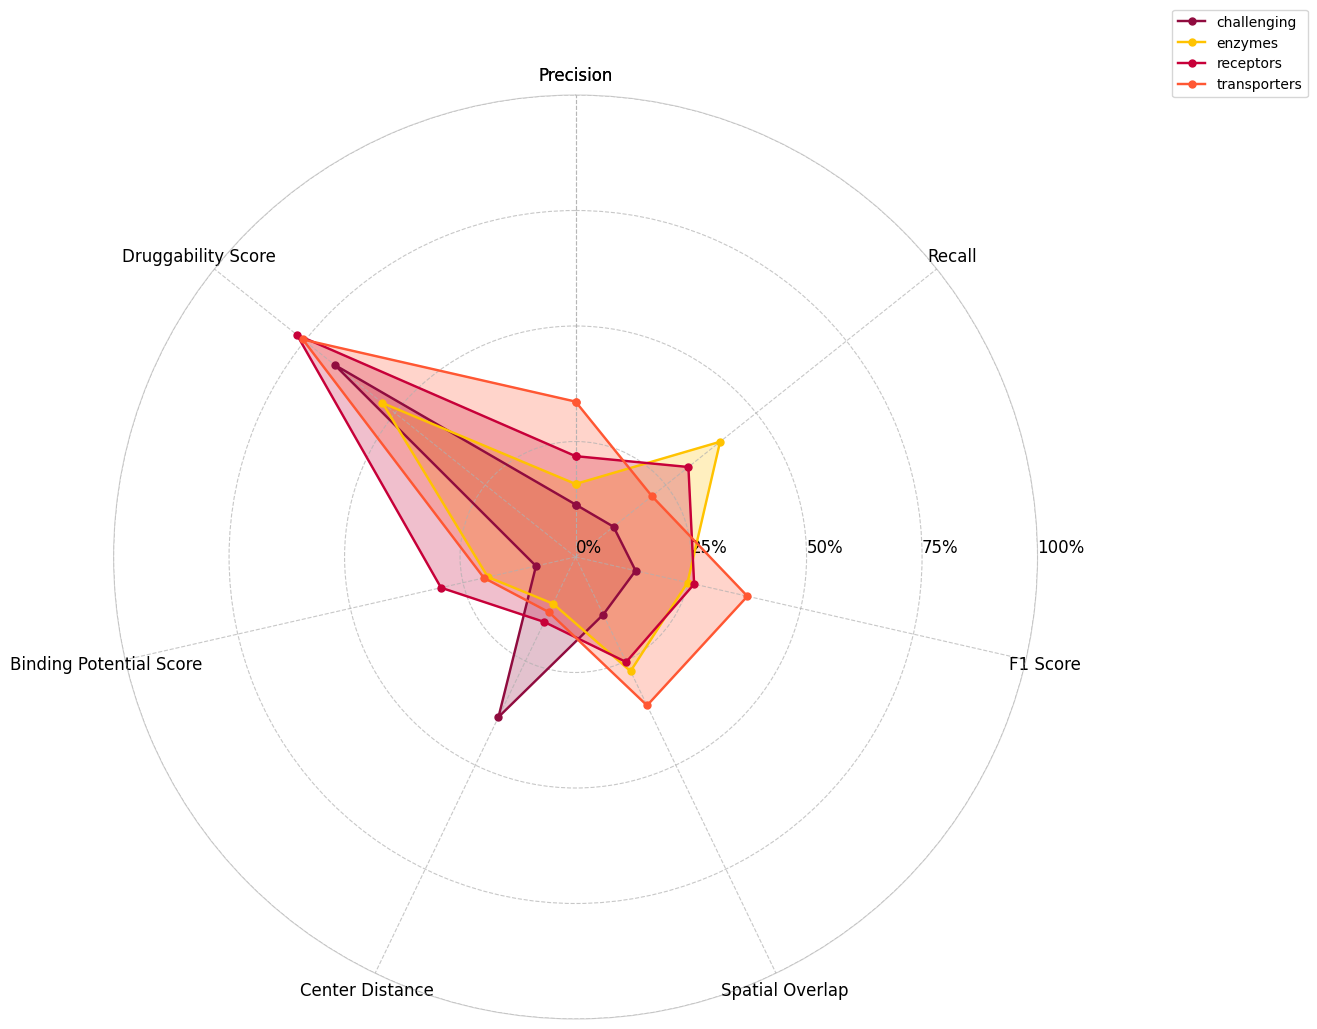

In [31]:
def radar_chart(data, metrics, labels, color_map):
    N = len(metrics)
    theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
    theta = np.concatenate([theta, [theta[0]]]) 
    
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': 'polar'})
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(90)
    ax.spines['polar'].set_zorder(1)
    ax.spines['polar'].set_color('lightgrey')
    
    for idx, (cls, row) in enumerate(data.iterrows()):
        values = row[metrics].values.flatten().tolist()
        values = values + [values[0]]
        ax.plot(theta, values, linewidth=1.75, linestyle='solid', 
                label=str(cls), marker='o', markersize=5, color=colfun[cls])
        ax.fill(theta, values, alpha=0.25, color=colfun[cls])
    
    plt.yticks([0, 0.25, 0.5, 0.75, 1.0], 
               ["0%", "25%", "50%", "75%", "100%"], 
               color="black", size=12)
    
    labels_with_first = labels + [labels[0]]  
    plt.xticks(theta, labels_with_first, color='black', size=12)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.grid(True, linestyle='--', alpha=0.7)
    return fig

metrics = [res[4], res[5], res[6], res[7], res[8], res[14], res[15]]
labs = [metric.replace('_', ' ').title() for metric in metrics]
means = results_df.groupby("protein_class")[metrics].mean()
    
scaled_means = means.copy()
for metric in metrics:
    min_val = results_df[metric].min()
    max_val = results_df[metric].max()
    if max_val > min_val:
        scaled_means[metric] = (means[metric] - min_val) / (max_val - min_val)
    else:
        scaled_means[metric] = means[metric] / means[metric].max() if means[metric].max() > 0 else means[metric]

fig = radar_chart(data=scaled_means, metrics=metrics, labels=labs, color_map=colfun)
plt.show()

- **Enzymes** stand out with **high recall**, meaning the algorithm consistently identifies their binding sites. However, this often comes at the cost of **precision**, with extra predicted pockets beyond the actual ligand site. This behavior aligns with enzymes typically having **well-defined, deeply buried active sites**—ideal targets for our geometric and knowledge-based detection components.
  
- **Transporters**, by contrast, exhibit a **more balanced performance** across all metrics. These proteins often feature **channel-like cavities or vestibules** that are accessible yet spatially distinct enough to be captured by both geometry and energy-based models. Their structural architecture makes them suitable for prediction but without the strong residue motifs seen in enzymes.
  
- **Challenging proteins** perform worst across most metrics, likely due to **shallow binding sites**, **lack of conserved residue patterns**, and **limited concavity**. Interestingly, however, they show **relatively better scores in druggability and knowledge-based features**, possibly reflecting their tendency to bind ligands at more exposed, chemically diverse surfaces.

These trends give us valuable qualitative insight, but to quantitatively determine **which protein types our algorithm handles best**, a **larger dataset is essential**. Our current evaluation is based on only five proteins per class: a size too small to generalize robust conclusions.

That said, even within this small set, we observe a meaningful signal in **center distance analysis**, which compares the predicted pocket centers with the true ligand positions. On this front, the algorithm consistently performs **best with enzymes**, suggesting it is most adept at detecting **functionally well-defined and geometrically enclosed active sites**. This superior localization performance likely stems from the strong convergence of geometric, energy, and knowledge.

### Best and Worst Case Predictions: Understanding Algorithm Behavior

To interpret the performance of our binding site prediction algorithm, it's essential to examine not just overall metrics, but the specific case studies that illustrate how the program behaves under favorable and challenging conditions:

Best performing cases:
PDB ID: 1RNM, Class: enzymes, Center Distance: 3.40
PDB ID: 2RH1, Class: challenging, Center Distance: 7.22
PDB ID: 1FKF, Class: receptors, Center Distance: 7.36
PDB ID: 1RBP, Class: transporters, Center Distance: 8.81
PDB ID: 2CBA, Class: enzymes, Center Distance: 10.10

Worst performing cases:
PDB ID: 6QEX, Class: challenging, Center Distance: 19.78
PDB ID: 1FM9, Class: receptors, Center Distance: 20.98
PDB ID: 1RDT, Class: receptors, Center Distance: 26.50
PDB ID: 4I8V, Class: challenging, Center Distance: 60.66
PDB ID: 2GIF, Class: challenging, Center Distance: 82.73


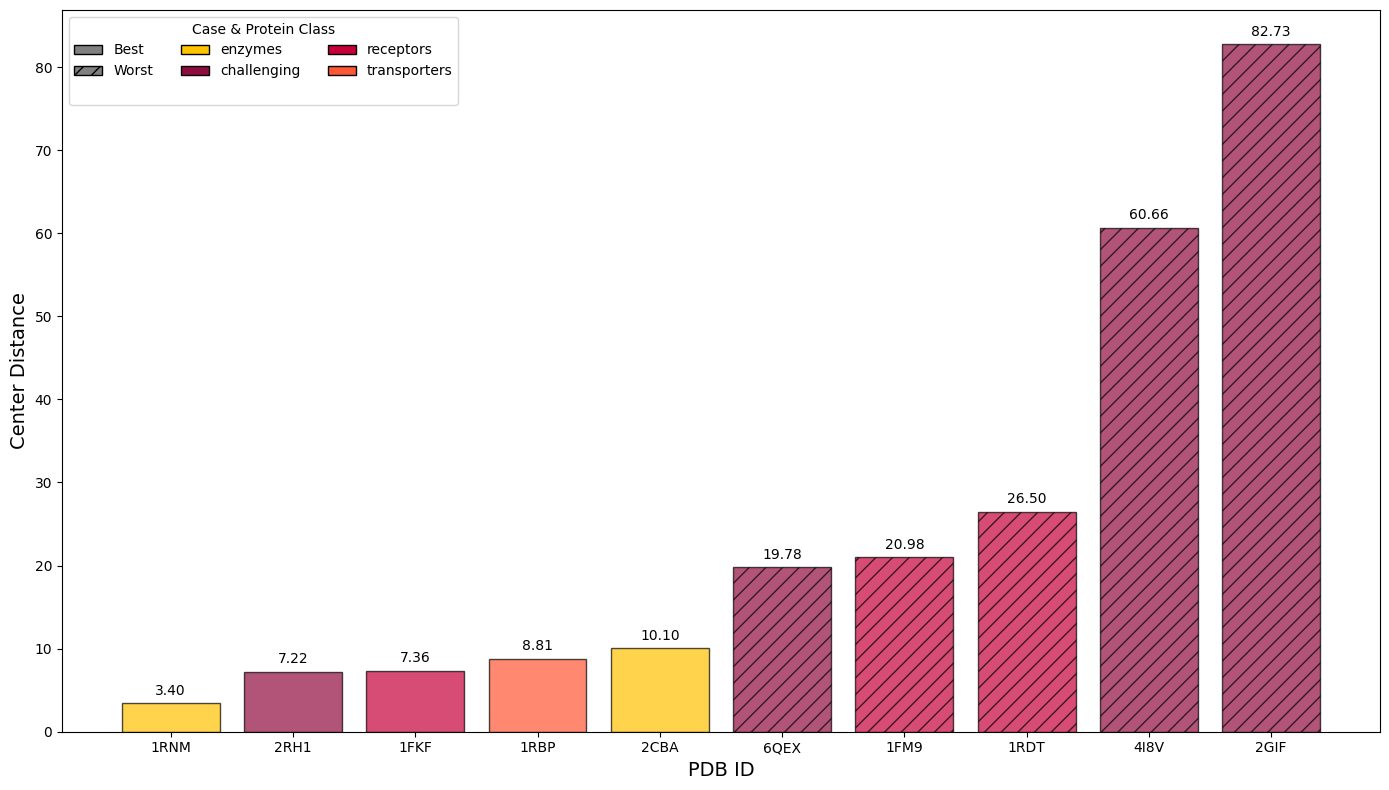

In [16]:
n_best = 5; n_worst = n_best
best_cases = results_df.sort_values('center_distance', ascending=True).head(n_best)
worst_cases = results_df.sort_values('center_distance', ascending=False).head(n_worst)[::-1]
    
print("Best performing cases:")
for _, case in best_cases.iterrows():
    print(f"PDB ID: {case['pdb_id']}, Class: {case['protein_class']}, Center Distance: {case['center_distance']:.2f}")  
print("\nWorst performing cases:")
for _, case in worst_cases.iterrows():
    print(f"PDB ID: {case['pdb_id']}, Class: {case['protein_class']}, Center Distance: {case['center_distance']:.2f}")
    
case_studies = pd.concat([best_cases, worst_cases])
case_studies['Performance'] = ['Best'] * n_best + ['Worst'] * n_worst
classes = case_studies['protein_class'].unique()

plt.figure(figsize=(14, 8))
ax = plt.subplot()
x_positions = np.arange(len(case_studies))
bar_width = 0.8

for i, (_, row) in enumerate(case_studies.iterrows()):
    pdb_id = row['pdb_id']
    performance = row['Performance']
    prot_class = row['protein_class']
    center_dist = row['center_distance']
    color = colfun[prot_class]
    hatch = '' if performance == 'Best' else '//'
    
    ax.bar(i, center_dist, width=bar_width, color=color, 
           edgecolor='black', hatch=hatch, alpha = 0.7)
    ax.text(i, center_dist + 1, f'{center_dist:.2f}', ha='center')

ax.set_xlabel('PDB ID', fontsize=14)
ax.set_ylabel('Center Distance', fontsize=14)
ax.set_xticks(x_positions)
ax.set_xticklabels(case_studies['pdb_id'])

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = []
legend_elements.append(Patch(facecolor='gray', edgecolor='black', label='Best'))
legend_elements.append(Patch(facecolor='gray', edgecolor='black', hatch='//', label='Worst'))
legend_elements.append(Line2D([0], [0], color='none', label=' '))
for pc in classes:
    legend_elements.append(Patch(facecolor=colfun[pc], 
                                 edgecolor='black',
                                 label=pc))
ax.legend(title = "Case & Protein Class", handles = legend_elements, loc = 'upper left', ncol = 3)

plt.tight_layout()
plt.show()

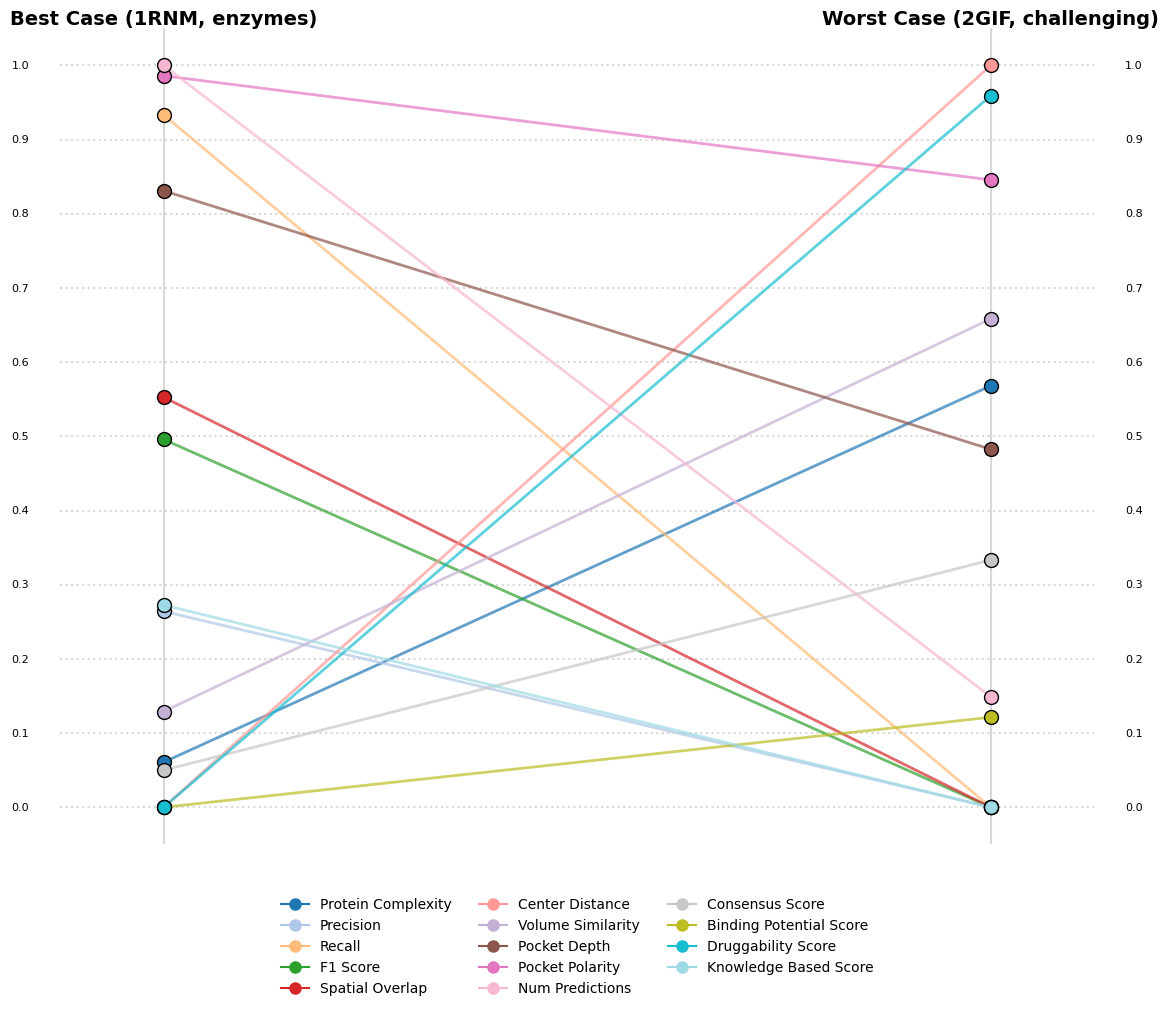

In [13]:
best_case = best_cases.iloc[0]; worst_case = worst_cases.iloc[4];
normalized_best = {}; normalized_worst = {}
metrics = [item for i, item in enumerate(res) if i not in [0, 1, 2, 17]]
for metric in metrics:
    min_val = results_df[metric].min()
    max_val = results_df[metric].max()
        
    normalized_best[metric] = (best_case[metric] - min_val) / (max_val - min_val)
    normalized_worst[metric] = (worst_case[metric] - min_val) / (max_val - min_val)
    
fig, ax = plt.subplots(figsize=(12, 10))
cmap = plt.get_cmap('tab20', len(metrics))
    
x_positions = [0.1, 0.9]  
ax.set_xlim(0, 1)
ax.set_ylim(-0.05, 1.05)
    
ax.axvline(x=x_positions[0], color='gray', linestyle='-', alpha=0.3)
ax.axvline(x=x_positions[1], color='gray', linestyle='-', alpha=0.3)
ax.text(x_positions[0], 1.05, f'Best Case ({best_cases.iloc[0]['pdb_id']}, {best_cases.iloc[0]['protein_class']})', ha='center', va='bottom', fontsize=14, fontweight='bold')
ax.text(x_positions[1], 1.05, f'Worst Case ({worst_cases.iloc[4]['pdb_id']}, {worst_cases.iloc[4]['protein_class']})', ha='center', va='bottom', fontsize=14, fontweight='bold')
    
for y in np.arange(0, 1.1, 0.1):
    ax.axhline(y=y, color='gray', linestyle=':', alpha=0.3)
    
for i, metric in enumerate(metrics):
    best_val = normalized_best[metric]
    worst_val = normalized_worst[metric]
        
    ax.plot([x_positions[0], x_positions[1]], [best_val, worst_val], 
            color=cmap(i), linewidth=2, alpha=0.7)
    ax.scatter([x_positions[0], x_positions[1]], [best_val, worst_val], 
               s=100, color=cmap(i), edgecolor='black', zorder=10)
    
for y in np.arange(0, 1.1, 0.1):
    ax.text(-0.03, y, f"{y:.1f}", ha='right', va='center', fontsize=8)
    ax.text(1.03, y, f"{y:.1f}", ha='left', va='center', fontsize=8)
    
for spine in ax.spines.values():
    spine.set_visible(False)
    
ax.set_xticks([])
ax.set_yticks([])
    
legend_handles = []
for i, metric in enumerate(metrics):
    legend_handles.append(
        plt.Line2D([0], [0], marker='o', color=cmap(i), 
                  markerfacecolor=cmap(i), markersize=8, 
                  label=metric.replace('_', ' ').title()))
    
ax.legend(handles=legend_handles, loc='upper center', 
          bbox_to_anchor=(0.5, -0.05), ncol=3, frameon=False)
    
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

#### Best Case: Enzyme 1RNM

The protein structure `1RNM` (a well-characterized enzyme) represents an ideal scenario for our algorithm. Here, the binding site is a deep, clearly defined cavity surrounded by catalytically important residues.

- **Geometric Success**: 
  - The cavity was easily detected using the default probe radius of `1.4Å`.
  - Concavity testing via ray-casting confirmed the pocket’s enclosed structure.
- **Knowledge-Based Signals**: 
  - Presence of a **Ser-His-Asp catalytic triad**, which increased the pocket’s score as it is considered in  catalytic patterns scoring.
  - Enzymatic logic applied: the presence of conserved residues increased confidence.
- **Energy-Based Support**:
  - The site had a hydrophobic core with favorable electrostatic environment.
  - Scoring based on Kyte-Doolittle and electrostatics confirmed high binding potential.
  
This case illustrates our method's strength when structural features align with biologically informed assumptions. Such enzyme-active sites are typically ideal for **high-recall, high-confidence** applications such as druggability assessment or active site annotation. The predicted center of this pocket lay only in a `3.40` distance away from the center of the true binding site, an excellent result that reflects strong alignment between prediction and biological reality.

#### Worst Case: Receptor-Like Protein 2GIF as a challenging case

In contrast, `2GIF` presents a significant challenge. This multi-domain protein lacks well-defined cavities and features a shallow, with an allosteric binding site on a relatively flat surface.

- **Geometric Limitations**:
  - Surface clustering probably did not produce cohesive binding regions.
- **Poor Energy Profile**:
  - No strong hydrophobic core or localized charge clusters.
  - Energy scoring yielded uniformly low values with no clear hotspots.
- **No Knowledge-Based Reinforcement**:
  - No known catalytic motifs or functional residue pairs.
  - No signals from patterns like aromatic clusters, heme sites, or glycine-rich loops.
- **Prediction Failure**:
  - Extremely high center distance from true binding site (**`82.73` distance**).
  - Precision, recall, and F1-score values were zero.

This outcome reveals a key limitation of the current implementation: proteins without deep pockets or conserved residue signatures—such as many receptors or challenging multi-domain structures are poorly served by geometry and rule-based heuristics. It underscores the need for **alternative methods**, such as conservation analysis or data-driven models, for these protein classes.

---

### Key Takeaways and Practical Implications

1. **Prediction quality of our algorithm is protein-type dependent**:
   - **Enzymes** often yield high recall and alignment thanks to deep cavities and known residue patterns.
   - **Transporters** benefit from large cavity boosts and clear structural channels, leading to good precision.
   - **Receptors**, especially those with surface-level or allosteric sites, present a challenge due to subtle or absent features.

2. **Different goals favor different performance profiles**:
   - For **ligand screening or active site detection**, models like `1RNM` with high recall are ideal.
   - For **functional annotation or docking**, higher precision models are preferred—even at the cost of recall.

3. **Understanding prediction context improves trust**:
   - Low consensus scores, high center distances, and lack of knowledge signals are red flags.
   - Interpreting these outputs correctly ensures that false positives or negatives are treated appropriately.

4. **Opportunities for improvement**:
   - Integrating **evolutionary conservation** could aid in recognizing functionally important surface sites.
   - **Machine learning models** may capture subtle patterns in complex proteins like 2GIF.
   - Predictive filters based on **center distance**, **consensus overlap**, or **protein complexity** could help flag unreliable predictions before deeper analysis.

> Results can vary slightly between runs due to randomized sampling in ray casting and clustering steps. Reproducibility improvements as well as possible enhancements in implementation are discussed in the notebook:
> 
>  [![Theory](https://img.shields.io/badge/Theory-purple?style=for-the-badge&logo=jupyter&logoColor=white)](Theory.ipynb)

***

# ⚠️ Edge Case Errors 

During the development and testing of **ConSBind**, two types of unexpected errors were identified when processing certain protein structures. These are considered **edge-case errors**, as they occur only in a small number of inputs and are typically linked to structural file inconsistencies or formatting issues.

To illustrate these issues, the PDB files `pdb1eve` and `pdb1atp` were used as **representative examples**. These structures are not inherently faulty but serve to demonstrate the two error types encountered during analysis.


## Error Type 1: Structural Format Warnings

- **Example**: `pdb1eve`
- **Description**: A warning was issued by Biopython's DSSP module indicating incomplete links in the `pdbx_branch_scheme` section:

```
UserWarning: Links for pdbx_branch_scheme:atom_site:1 are incomplete
```

- **Impact**: Despite this warning, files are processed successfully and valid predictions are generated. 


## Error Type 2: Type Mismatch in Energy Scoring

- **Example**: `pdb1atp`
- **Description**: A fatal error occurred during the energy-based pocket detection step:

```
'>' not supported between instances of 'str' and 'float'
```

- **Cause**: This error may be caused by malformed structural file entries where a string is passed into a numerical comparison, indicating a parsing issue or invalid value.
- **Impact**: The files can't be fully processed and no predictions are generated.

## Possible Improvements

To handle these edge cases more robustly, the following improvements could be done:

- Enhanced input validation
- Type-checking and fallback logic to prevent runtime errors
- Expanded error reporting to help users diagnose and resolve problematic files

## Errors Demonstration:

In [14]:
cmd = f"consbind {Path(os.getcwd()) / "data" / "errors"} --output_dir {"results/analysis"}"
!{cmd}

2025-04-10 16:32:59 - INFO - Input directory: errors
2025-04-10 16:32:59 - INFO - Found 2 PDB files in /Users/claudiavicentecomorera/Desktop/MSc/ConSBind/data/errors
2025-04-10 16:32:59 - INFO - Converting .ent file to .pdb format: pdb1eve.ent
2025-04-10 16:32:59 - INFO - Converted to: pdb1eve.pdb
2025-04-10 16:32:59 - INFO - Converting .ent file to .pdb format: pdb1atp.ent
2025-04-10 16:32:59 - INFO - Converted to: pdb1atp.pdb
2025-04-10 16:32:59 - INFO - Found 2 PDB files to process
2025-04-10 16:32:59 - INFO - Processing: pdb1eve.pdb
/Users/claudiavicentecomorera/miniconda3/lib/python3.12/site-packages/Bio/PDB/DSSP.py:199: UserWarning: Links for pdbx_branch_scheme:atom_site:1 are incomplete
  There are 2 items in pdbx_branch_scheme that don't have matching parent items in atom_site
Resulting mmCIF file is not valid!

  warnings.warn(err)
2025-04-10 16:33:02 - INFO - Created grid with dimensions: 85x86x85
2025-04-10 16:33:04 - INFO - Found 1039 potential cavity points
2025-04-10 16:3